# Predicting Personality from Text – An Analysis of Multi-Label Classification Methods

## Background

Carl Jung, founder of the field of analytical psychology, formulated a personality theory aiming to categorize people based on how they process information. He identified two types of cognitive functions: two perception functions known as sensation and intuition, and two judgement functions known as thinking and feeling. The functions within each pair are considered to be opposites of each other. 

<img src="images/cognitive_functions_diagram.png"  alt="drawing" width="325"/>

Additionally, these four functions operate in conjunction with either an introverted or extroverted attitude. This results in eight functional variations, or personality types: extroverted sensing (Se), introverted sensing (Si), extroverted intuition (Ne), introverted intuition (Ni), extroverted feeling (Fe), introverted feeling (Fi), extroverted thinking (Te), and introverted thinking (Ti). 

All four cognitive functions are used at different times depending on the circumstances. However, one of the four functions tend to be used more frequently than the other three in a more conscious and confident way. This dominant function is supported by two auxiliary functions. The dominant and first auxiliary are referred to as the two primary cognitive functions, and are of different cognitive function type: for example, if the dominant function is a judging type, then the first auxillary will be a perceiving type and vice versa. The fourth and least conscious function, often referred to as the inferior function, is always the opposite of the dominant function in terms of cognitive function and attitude. For example, an extroverted thinking dominant function would be balanced by an introverted feeling inferior function. Jung theorized that the dominant function characterizes conscious behavior, while the inferior function is repressed and characterizes unconscious behavior.

Jung's personality theory formed the basis of the Myers-Briggs Type Indicator (MBTI) which is a widely used method of self-categorization of personality type through an introspective questionnaire. The relationships between MBTI type and Jungian cognitive functions are shown below. Primary cognitive functions are highlighted in green.

<img src="images/mbti_cognitive_functions_relationship.png"  alt="drawing" width="175"/>



## Objective

The objective is to develop a machine learning model which can can accurately predict a person's two primary cognitive functions based off of what they have written. In doing so, the following multi-label classification techniques are implemented and compared: 

<ol start="1">
  <li><b>Problem transformation, algorithm adaptation, and ensemble approaches</b></li>
 
<ol type="a">
  <li>Problem transformation approaches</li>
      •  Binary relevance<br>      •  Classifier chain<br>      •  Label powerset<br>  <li>Algorithm adaptation approaches</li>
      •  Multi-label k-nearest neighbors (MLkNN)<br>      •  Multi-label hierarchical ARAM neural network (MLARAM)<br>    <li>Ensembles of classifiers</li>
      •  Random label space partitioning with label powerset (RAkELd)<br></ol>
  <li><b>Neural networks using Keras</b></li>
      •  Long short-term memory networks (LSTM)<br>      •  1D convolutional neural networks (CNN)<br>  <li><b>Bidirectional Encoder Representations from Transformers (BERT)</b></li>  </ol>

The [dataset](https://data.world/just4jcgeorge/myers-briggs-personality-type-test-dataset) used contains a large selection of people's MBTI personality types and text they have written on a forum called Personality Cafe: a community dedicated to discussion about personality types.




## Import Libraries <a class="anchor" id="import-libraries"></a>

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import logging
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
import torch

# Problem transformation, algorithm adaptation, and ensemble approaches
!pip install -q scikit-multilearn
from skmultilearn.problem_transform import LabelPowerset
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, classification_report
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from skmultilearn.ensemble import RakelD, RakelO
from skmultilearn.adapt import MLkNN, MLARAM

# Neural networks using Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Dense, Activation, Conv1D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from keras.constraints import max_norm, unit_norm

# BERT
!pip install transformers
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm, trange
from torch.nn import BCEWithLogitsLoss, BCELoss


In [75]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Mounted at drive


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load and Preprocess the Data <a class="anchor" id="load-preprocess"></a>

The dataset consists of 8675 rows and 2 columns. Each row provides a user's MBTI type and their last 50 posts with each entry separated by three pipe characters.

In [6]:
df = pd.read_csv('mbti_1.csv')
print(df.shape)
df.head()

(8675, 2)


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### Clean dataset

In [7]:
def remove_pipe_characters(df):   
    posts_pipes_removed = [] 

    for row in df.iterrows():
        split_row = df['posts'][row[0]].split('|||')
        posts_pipes_removed.append(' '.join(split_row))
    
    df['posts'] = posts_pipes_removed
    

remove_pipe_characters(df)

The goal is to create a model that can be used on text outside of a personality forum like Personality Cafe. Here we remove words which explicitly relate to personality theory since they may introduce some bias in our models. For example, people who write "Fi" are more likely to possess the Fi cognitive function. 


In [8]:
to_remove = ['mbti','infps','infjs','isfps','isfjs','enfps','enfjs','entjs','intjs','estps','estjs','istps','istjs', 'infp','infj','intp','intj','entp','enfp','entj','enfj','isfp','isfj','esfj','esfp','estj','estp','istp','istj','fi','fe','ti','te','si','se','ni','ne']

def remove_personality_words(df):
  personality_words_removed = []

  for post in df.posts:
    split_post = post.split()
    edited_post = [word for word in split_post if word.lower() not in to_remove]
    edited_post = ' '.join(edited_post)
    personality_words_removed.append(edited_post)
  
  df['posts'] = personality_words_removed

remove_personality_words(df)


### Initial distribution of cognitive functions

In [9]:
# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

df["Ne"] = [1 if x[-1] == 'P' and x[1] == 'N' else 0 for x in df.iloc[:,0]]
df["Ni"] = [1 if x[-1] == 'J' and x[1] == 'N' else 0 for x in df.iloc[:,0]]
df["Se"] = [1 if x[-1] == 'P' and x[1] == 'S' else 0 for x in df.iloc[:,0]]
df["Si"] = [1 if x[-1] == 'J' and x[1] == 'S' else 0 for x in df.iloc[:,0]]
df["Fi"] = [1 if x[-1] == 'P' and x[2] == 'F' else 0 for x in df.iloc[:,0]]
df["Fe"] = [1 if x[-1] == 'J' and x[2] == 'F' else 0 for x in df.iloc[:,0]]
df["Ti"] = [1 if x[-1] == 'P' and x[2] == 'T' else 0 for x in df.iloc[:,0]]
df["Te"] = [1 if x[-1] == 'J' and x[2] == 'T' else 0 for x in df.iloc[:,0]]
df = df.drop(columns=['type'])

Text(0, 0.5, 'Count')

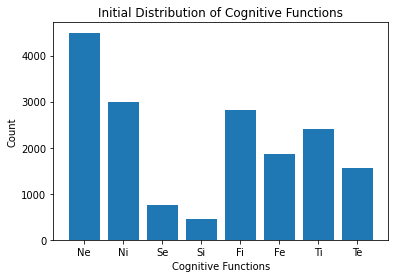

In [10]:
cols = df.columns
label_cols = list(cols[1:10])

plt.bar(label_cols,df[label_cols].sum())
plt.title("Initial Distribution of Cognitive Functions")
plt.xlabel("Cognitive Functions")
plt.ylabel("Count")

Since class imbalance can diminish the performance of our models, it is favorable to randomly resample the data in order to obtain a more balanced distribution. Here we will accomplish that using random oversampling.

### Random oversampling 

First, we tokenize the dataset for use in RandomOverSampler and our models later on:

In [11]:
logging.basicConfig(level=logging.ERROR)

X = list(df.posts.values)

max_length = 100

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer
encodings = tokenizer.batch_encode_plus(X, max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method



In [12]:
X = np.array(encodings['input_ids'])
y = df[label_cols].to_numpy()

In [13]:
lp = LabelPowerset()
ros = RandomOverSampler(random_state=42)

y = lp.transform(y)

X, y = ros.fit_sample(X, y)

In [14]:
X.shape, y.shape

((20056, 100), (20056,))

Text(0, 0.5, 'Count')

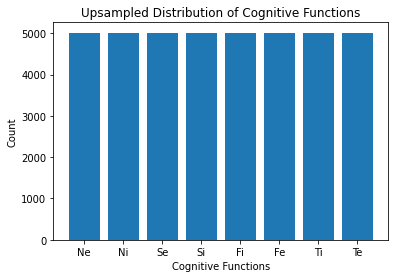

In [15]:
y = lp.inverse_transform(y).toarray().tolist()

resampled_counts = np.array(y).sum(axis=0)

plt.bar(label_cols, resampled_counts)
plt.title("Upsampled Distribution of Cognitive Functions")
plt.xlabel("Cognitive Functions")
plt.ylabel("Count")

### Split into train and test sets

In [16]:
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9000)

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16044, 100), (16044, 8), (4012, 100), (4012, 8))

## Problem transformation, algorithm adaptation, and ensemble approaches




The scikit-multilearn library contains a selection of classifiers for multi-label classification, and each of these classifiers fall under a particular category. The classifiers examined here, and their corresponding categories, are summed up again here:  
<ol start = "1">
  <li><b>Problem transformation approaches</b> convert a multi-label problem into one or more single label problems. This allows for the use of any conventional single-label machine learning algorithm.</li>
    <ul type="disc">
      <li>Binary relevance</li>
      <li>Classifier chain</li>
      <li>Label powerset</li>
    </ul>
  <li><b>Algorithm adaptation approaches</b> convert single-label machine learning algorithms for direct use with multi-labeled data.</li>
    <ul type="disc">
        <li>Multi-label k-nearest neighbors (MLkNN)</li> 
        <li>Multi-label hierarchical ARAM neural network (MLARAM)</li>      
    </ul>
    <li><b>Ensembles of classifiers</b> construct ensembles of base multi-label classifiers. For example, RAkELd divides the label space into equal partitions, and trains a label powerset with base classifier per partition. Predictions are made by summing the results of all trained classifiers.</li>
    <ul type="disc">
        <li>Random label space partitioning with label powerset (RAkELd)</li>  
    </ul>
</ol>


In [ ]:
def problem_transformation_grid_search(prob_trans):

    parameters = [
        {
            'classifier': [LogisticRegression()],
            'classifier__penalty': ['l1', 'l2'],
            'classifier__C': [0.009, 0.001, 0.09, 0.01, 1, 5, 10, 25],
        },
        {
            'classifier': [MultinomialNB()],
            'classifier__alpha': [0.7, 1.0],
        },
        {
            'classifier': [GaussianNB()]

        },
    ]

    score = 'accuracy'

    clf = GridSearchCV(prob_trans, parameters, scoring=score)
    clf.fit(X_train, y_train)
    
    return (clf.best_params_)

Each approach evaluated contains a `predict_proba(X)` method which returns the predicted probabilities of label assignments for X. By default, predictions are made based on a threshold value of 0.5 meaning that probabilies greater than or equal to 0.5 are converted to 1's and the rest to 0's. Here, for each approach, we evaluate all thresholds from 0.1 to 0.9 in order to find each optimal threshold. This, combined with hyperparameter optimization using grid search, allows us to compare each approach on the basis of their highest performance possible on this dataset.

In [ ]:
def evaluate_thresholds(method, base_classifier, thresholds, X_train, X_test, y_train, y_test):
    fig, ax1 = plt.subplots()
    
    if method == None:
      classifier = base_classifier
      classifier_name = str(base_classifier).split('(')[0]
      plt.title(classifier_name)
    else:
      classifier = method(base_classifier)
      method_name = method.__name__
      base_classifier_name = str(base_classifier).split('(')[0]
      plt.title("{} + {}".format(method_name, base_classifier_name))

    metrics = {'accuracy': [], 'f1_score': []}
    hl = []
    counts = []
    for threshold in thresholds:
      classifier.fit(X_train, y_train)
      classifier_predicted_probabilities = classifier.predict_proba(X_test)
      y_pred = (classifier_predicted_probabilities >= threshold).astype(int)
      
      metrics['accuracy'].append(accuracy_score(y_test, y_pred))
      metrics['f1_score'].append(f1_score(y_test, y_pred, average='micro'))

    color1 = 'tab:red'
    ax1.set_xlabel('Thresholds')
    ax1.set_ylabel('Accuracy', color=color1)
    ax1.plot(thresholds, metrics['accuracy'], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:blue'
    ax2.set_ylabel('F1 Score', color=color2)
    ax2.plot(thresholds, metrics['f1_score'], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)

    fig.tight_layout() 
    plt.show()

    return metrics


Method = BinaryRelevance
Performing grid search...
Grid search result: MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True)
Evaluating thresholds...


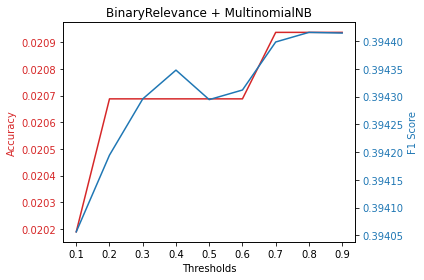

Method = ClassifierChain
Performing grid search...
Grid search result: GaussianNB(priors=None, var_smoothing=1e-09)
Evaluating thresholds...


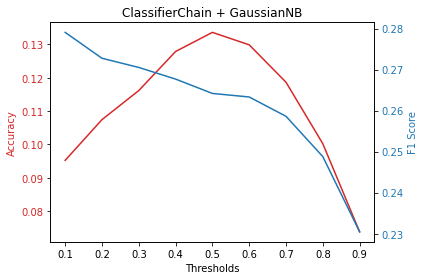

Method = LabelPowerset
Performing grid search...
Grid search result: LogisticRegression(C=0.09, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Evaluating thresholds...


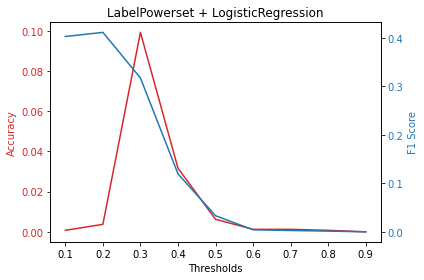

Method = MLkNN
Performing grid search...
Grid search result: {'k': 1, 's': 0.5}
Evaluating thresholds...


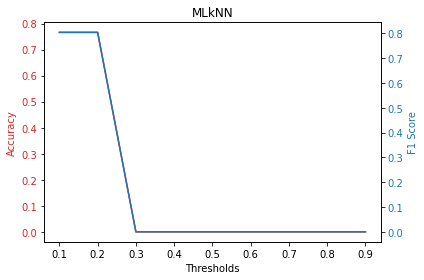

Method = MLARAM
Evaluating thresholds...


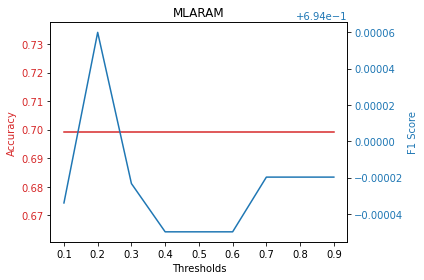

Method = RakelD
Evaluating thresholds...


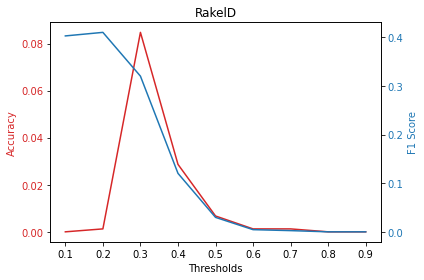

In [ ]:
multilabel_classification_methods = {'Problem Transformation': [BinaryRelevance, ClassifierChain, LabelPowerset], 'Algorithm Adaptation': [MLkNN, MLARAM], 'Ensembles': [RakelD]}

# multilabel_classification_methods = [BinaryRelevance, ClassifierChain, LabelPowerset, MLkNN]
base_classifiers = []
thresholds = np.arange(0.1, 1, 0.1)
all_metrics = {'BinaryRelevance': {}, 'ClassifierChain': {}, 'LabelPowerset': {}, 'MLkNN': {}, 'MLARAM': {}, 'RakelD': {}}

# For each problem transformation method, determine the optimal combination of base classifier and hyperparameter values
for approach, methods in multilabel_classification_methods.items():
  for method in methods:
    print("Method =", method.__name__)
    if method.__name__ == 'MLkNN':
      parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
      score = 'accuracy'
      print('Performing grid search...')
      clf = GridSearchCV(MLkNN(), parameters, scoring=score)
      clf.fit(X_train, y_train)
      grid_search_result = clf.best_params_

      print('Grid search result:', grid_search_result)
      classifier = MLkNN(k=grid_search_result['k'], s=grid_search_result['s'])
      base_classifiers.append('-')
      
      print('Evaluating thresholds...')
      metrics = evaluate_thresholds(None, classifier, thresholds, X_train, X_test, y_train, y_test)
      all_metrics[str(classifier).split('(')[0]] = metrics
    elif method.__name__ == 'MLARAM':
      classifier = MLARAM(threshold=0.05, vigilance=0.95)
      base_classifiers.append('-')

      print('Evaluating thresholds...')
      metrics = evaluate_thresholds(None, classifier, thresholds, X_train, X_test, y_train, y_test)
      all_metrics[str(classifier).split('(')[0]] = metrics
    elif method.__name__ == 'RakelD':
      classifier = RakelD(LogisticRegression(penalty='l2', C=5))
      base_classifiers.append('-')
      
      print('Evaluating thresholds...')
      metrics = evaluate_thresholds(None, classifier, thresholds, X_train, X_test, y_train, y_test)
      all_metrics[str(classifier).split('(')[0]] = metrics
  
    else:
      print('Performing grid search...')
      grid_search_result = problem_transformation_grid_search(method())
      base_classifier = grid_search_result['classifier']
      
      print('Grid search result:', base_classifier)
      base_classifiers.append(str(base_classifier).split('(')[0])

      print('Evaluating thresholds...')
      metrics = evaluate_thresholds(method, base_classifier, thresholds, X_train, X_test, y_train, y_test)
      all_metrics[method.__name__] = metrics



In [ ]:
summary = pd.DataFrame()
summary['Method'] = [i.__name__ for i in np.concatenate(list(multilabel_classification_methods.values()))]
summary['Base Classifier'] = base_classifiers
summary['Accuracy'] = [all_metrics['BinaryRelevance']['accuracy'][3], all_metrics['ClassifierChain']['accuracy'][4], all_metrics['LabelPowerset']['accuracy'][2], all_metrics['MLkNN']['accuracy'][0], all_metrics['MLARAM']['accuracy'][-1], all_metrics['RakelD']['accuracy'][2]]
summary['F1 Score'] = [all_metrics['BinaryRelevance']['f1_score'][3], all_metrics['ClassifierChain']['f1_score'][4], all_metrics['LabelPowerset']['f1_score'][2], all_metrics['MLkNN']['f1_score'][0], all_metrics['MLARAM']['f1_score'][-1], all_metrics['RakelD']['f1_score'][2]]
summary

,Method,Base Classifier,Accuracy,F1 Score
0,BinaryRelevance,MultinomialNB,0.020688,0.394348
1,ClassifierChain,GaussianNB,0.133599,0.264186
2,LabelPowerset,LogisticRegression,0.099202,0.317147
3,MLkNN,-,0.766201,0.804212
4,MLARAM,-,0.699153,0.693980
5,RakelD,-,0.084746,0.320146


## Neural networks using Keras

Here we evaluate the use of LSTMs and 1D CNNs on our multi-label classification problem. We additionally implement a simple baseline model which only consists of an embedding layer, a dropout layer to prevent overfititng, a max pooling layer, and one dense layer with a sigmoid activation function. 10-fold cross-validation is used when evaluating each model.




In [51]:
# Combine train and test in preparation for KFold
X = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)])
y = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_test)])

vocab_size = tokenizer.vocab_size

In [52]:
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Dense, Activation, Conv1D, LSTM, Embedding

baseline_model = tf.keras.Sequential()
baseline_model.add(Embedding(vocab_size, 20, input_length=100))
baseline_model.add(Dropout(0.2))
baseline_model.add(GlobalMaxPool1D())
baseline_model.add(Dense(8, activation='sigmoid', kernel_constraint=unit_norm()))

lstm_model = tf.keras.Sequential()
lstm_model.add(Embedding(vocab_size, 20, input_length=100))
lstm_model.add(Dropout(0.1))
lstm_model.add(LSTM(128, return_sequences=True, kernel_constraint=unit_norm()))
lstm_model.add(GlobalMaxPool1D())
lstm_model.add(Dense(8))
lstm_model.add(Activation('sigmoid'))

cnn_model = tf.keras.Sequential()
cnn_model.add(Embedding(vocab_size, 20, input_length=100))
cnn_model.add(Dropout(0.1))
cnn_model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1, kernel_constraint=max_norm()))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dense(8))
cnn_model.add(Activation('sigmoid'))

models = [baseline_model, lstm_model, cnn_model]
model_names = ['Baseline Model', 'LSTM Model', 'CNN Model']

baseline_cv_scores = {'Train': {'accuracy': [], 'loss': [], 'f1_score': []}, 'Test': {'accuracy': [], 'loss': [], 'f1_score': []}}
lstm_cv_scores = {'Train': {'accuracy': [], 'loss': [], 'f1_score': []}, 'Test': {'accuracy': [], 'loss': [], 'f1_score': []}}
cnn_cv_scores = {'Train': {'accuracy': [], 'loss': [], 'f1_score': []}, 'Test': {'accuracy': [], 'loss': [], 'f1_score': []}}
all_cv_scores = [baseline_cv_scores, lstm_cv_scores, cnn_cv_scores]

predictions = {'Baseline Model': [], 'LSTM Model': [], 'CNN Model': []}

In [53]:
# Manually determine f1 score for Keras models

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [54]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
kfold = KFold(n_splits=10, shuffle=True, random_state=7)

for i in range(len(models)):
  train_idx = []
  test_idx = []
  print("Training", model_names[i])
  for train, test in kfold.split(X, y):
    train_idx.append(train)
    test_idx.append(test)
    models[i].compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_m])

    callbacks = [
      ReduceLROnPlateau(),
      EarlyStopping(patience=4),
      ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)]

    models[i].fit(X.iloc[train], y.iloc[train],
                      epochs=20,
                      batch_size=32,
                      validation_split = 0.25,
                      callbacks=callbacks)
    
    
    train_loss, train_accuracy, train_f1 = models[i].evaluate(X.iloc[train], y.iloc[train], verbose=0)
    test_loss, test_accuracy, test_f1 = models[i].evaluate(X.iloc[test], y.iloc[test], verbose=0)

    print("Train: accuracy = {:.2f}%, loss = {:.2f}%, f1 score = {:.2f}%".format(train_accuracy*100, train_loss, train_f1*100))
    all_cv_scores[i]['Train']['accuracy'].append(round(train_accuracy, 2))
    all_cv_scores[i]['Train']['loss'].append(round(train_loss, 2))
    all_cv_scores[i]['Train']['f1_score'].append(round(train_f1, 2))
    print("Test: accuracy = {:.2f}%, loss = {:.2f}%, f1 score = {:.2f}%".format(test_accuracy*100, test_loss, test_f1*100)) 
    all_cv_scores[i]['Test']['accuracy'].append(round(test_accuracy, 2))
    all_cv_scores[i]['Test']['loss'].append(round(test_loss, 2))
    all_cv_scores[i]['Test']['f1_score'].append(round(test_f1, 2))

  prediction = models[i].predict(X.iloc[test_idx[-1]])
  predictions[model_names[i]].append(prediction)

  # Compute average metrics
  all_cv_scores[i]['Train']['accuracy'] = str(round((sum(all_cv_scores[i]['Train']['accuracy']) / len(all_cv_scores[i]['Train']['accuracy']))*100, 2))+'%'
  all_cv_scores[i]['Train']['loss'] = str(round(sum(all_cv_scores[i]['Train']['loss']) / len(all_cv_scores[i]['Train']['loss']),2))+'%'
  all_cv_scores[i]['Train']['f1_score'] = str(round((sum(all_cv_scores[i]['Train']['f1_score']) / len(all_cv_scores[i]['Train']['f1_score']))*100, 2))+'%'
  all_cv_scores[i]['Test']['accuracy'] = str(round((sum(all_cv_scores[i]['Test']['accuracy']) / len(all_cv_scores[i]['Test']['accuracy']))*100, 2))+'%'
  all_cv_scores[i]['Test']['loss'] = str(round(sum(all_cv_scores[i]['Test']['loss']) / len(all_cv_scores[i]['Test']['loss']),2))+'%'
  all_cv_scores[i]['Test']['f1_score'] = str(round((sum(all_cv_scores[i]['Test']['f1_score']) / len(all_cv_scores[i]['Test']['f1_score']))*100, 2))+'%'

  print("Average baseline metrics for {}:".format(model_names[i]), all_cv_scores[i])

Average baseline metrics for Baseline Model: {'Train': {'accuracy': '49.8%', 'loss': '2.37%', 'f1_score': '0.0%'}, 'Test': {'accuracy': '48.2%', 'loss': '2.43%', 'f1_score': '0.1%'}}
Average baseline metrics for LSTM Model: {'Train': {'accuracy': '47.3%', 'loss': '1.93%', 'f1_score': '90.8%'}, 'Test': {'accuracy': '49.3%', 'loss': '2.09%', 'f1_score': '89.0%'}}
Average baseline metrics for CNN Model: {'Train': {'accuracy': '62.8%', 'loss': '2.08%', 'f1_score': '89.9%'}, 'Test': {'accuracy': '64.9%', 'loss': '2.25%', 'f1_score': '88.8%'}}


In [58]:
nn_summary = pd.DataFrame()
nn_summary['Model'] = model_names
nn_summary['Train accuracy'] = [score['Train']['accuracy'] for score in all_cv_scores]
nn_summary['Train loss'] = [score['Train']['loss'] for score in all_cv_scores]
nn_summary['Train f1 score'] = [score['Train']['f1_score'] for score in all_cv_scores]
nn_summary['Test accuracy'] = [score['Test']['accuracy'] for score in all_cv_scores]
nn_summary['Test loss'] = [score['Test']['loss'] for score in all_cv_scores]
nn_summary['Test f1 score'] = [score['Train']['f1_score'] for score in all_cv_scores]
nn_summary

,Model,Train accuracy,Train loss,Train f1 score,Test accuracy,Test loss,Test f1 score
0,Baseline Model,49.8%,2.37%,0.0%,48.2%,2.43%,0.0%
1,LSTM Model,47.3%,1.93%,90.8%,49.3%,2.09%,90.8%
2,CNN Model,62.8%,2.08%,89.9%,64.9%,2.25%,89.9%


## BERT

BERT, released by Google in October 2018, is a contextual model that is based on the [transformer architecture](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf). It is the first language representation that is deeply bidirectional, unsupervised, and pre-trained using only a plain text corpus. Here we adapt BERT for multi-label classification and compare it to earlier models.

In [18]:
X_train_decoded = tokenizer.batch_decode(X_train)

encodings = tokenizer.batch_encode_plus(X_train_decoded,max_length=max_length,pad_to_max_length=True)
X_train = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [20]:
y_train = list(y_train)
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = pd.Series(y_train).astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(pd.Series(y_train)[pd.Series(y_train).astype(str).isin(one_freq)].index), reverse=True)
print('train_df label indices with only one instance: ', one_freq_idxs)

train_df label indices with only one instance:  []


In [21]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [X_train.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [y_train.pop(i) for i in one_freq_idxs]

In [22]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(X_train, y_train, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10, stratify = y_train)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [23]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [24]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

### Load model and set parameters

In [25]:
# Load model, the pretrained model will include a single linear classification layer on top for classification. 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=8)
model.cuda()

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [26]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)

### Train model

In [35]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1, 8),b_labels.type_as(logits).view(-1, 8)) #convert labels to float for calculation

    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format((tr_loss/nb_tr_steps)*100))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('Validation F1 Score: ', val_f1_accuracy)
  print('Validation Accuracy: ', val_flat_accuracy)




Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 16.944092703340328




Epoch:  33%|███▎      | 1/3 [02:19<04:38, 139.01s/it]

Validation F1 Score:  78.48707309288221
Validation Accuracy:  67.72585669781932
Train loss: 9.60335345460778




Epoch:  67%|██████▋   | 2/3 [04:37<02:18, 138.99s/it]

Validation F1 Score:  80.01254115065058
Validation Accuracy:  71.8380062305296
Train loss: 6.085545459218257




Epoch: 100%|██████████| 3/3 [06:56<00:00, 138.96s/it]

Validation F1 Score:  81.7754077791719
Validation Accuracy:  75.14018691588785


In [28]:
torch.save(model.state_dict(), 'bert_model_cognitive_functions')

### Load and preprocess test data

In [29]:
# Encoding input data
X_test_decoded = tokenizer.batch_decode(X_test)
test_encodings = tokenizer.batch_encode_plus(X_test_decoded,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

In [30]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(y_test)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

### Prediction and metics

In [36]:
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch
  with torch.no_grad():
    # Forward pass
    outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label = pred_label.to('cpu').numpy()
    b_labels = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

We need to threshold our sigmoid function outputs which range from [0, 1]. Here we use 0.5 as a threshold.

In [37]:
from sklearn.metrics import classification_report
import pickle
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Score: ', f1_score(true_bools, pred_bools,average='micro'))
print('Test Accuracy: ', accuracy_score(true_bools, pred_bools),'\n')
clf_report = classification_report(true_bools,pred_bools,target_names=label_cols)
pickle.dump(clf_report, open('classification_report.txt','wb')) #save report
print(clf_report)

Test F1 Score:  0.839332748024583
Test Accuracy:  0.7876370887337986 

              precision    recall  f1-score   support

          Ne       0.71      0.74      0.72       952
          Ni       0.75      0.73      0.74      1036
          Se       0.98      0.98      0.98      1037
          Si       0.99      1.00      0.99       987
          Fi       0.78      0.78      0.78      1007
          Fe       0.82      0.78      0.80      1023
          Ti       0.83      0.79      0.81       982
          Te       0.89      0.88      0.88      1000

   micro avg       0.84      0.83      0.84      8024
   macro avg       0.84      0.83      0.84      8024
weighted avg       0.84      0.83      0.84      8024
 samples avg       0.84      0.83      0.84      8024



### Output

In [38]:
idx2label = dict(zip(range(8),label_cols))
print(idx2label)

{0: 'Ne', 1: 'Ni', 2: 'Se', 3: 'Si', 4: 'Fi', 5: 'Fe', 6: 'Ti', 7: 'Te'}


In [39]:
# Getting indices of where boolean one hot vector true_bools is True so we can use idx2label to gather label names
true_label_idxs, pred_label_idxs=[],[]
for vals in true_bools:
  true_label_idxs.append(np.where(vals)[0].flatten().tolist())
for vals in pred_bools:
  pred_label_idxs.append(np.where(vals)[0].flatten().tolist())

In [40]:
# Gathering vectors of label names using idx2label
true_label_texts, pred_label_texts = [], []
for vals in true_label_idxs:
  if vals:
    true_label_texts.append([idx2label[val] for val in vals])
  else:
    true_label_texts.append(vals)

for vals in pred_label_idxs:
  if vals:
    pred_label_texts.append([idx2label[val] for val in vals])
  else:
    pred_label_texts.append(vals)

In [41]:
# Decoding input ids to comment text
comment_texts = [tokenizer.decode(text,skip_special_tokens=True,clean_up_tokenization_spaces=False) for text in tokenized_texts]

In [42]:
# Converting lists to df
comparisons_df = pd.DataFrame({'comment_text': comment_texts, 'true_labels': true_label_texts, 'pred_labels':pred_label_texts})
comparisons_df.to_csv('comparisons.csv')
comparisons_df.head()

,comment_text,true_labels,pred_labels
0,' thetechman if it ' s due to circumstances ? ...,"[Se, Ti]","[Se, Ti]"
1,"' also , try going for community college for t...","[Ne, Ti]","[Ne, Ti]"
2,' i have had problems with him all my life . p...,"[Ne, Ti]","[Ne, Ti]"
3,' but for various reasons taylor swift ' s rel...,"[Ne, Ti]","[Ni, Fe]"
4,' this happens to me ! it usually happens when...,"[Se, Ti]","[Se, Ti]"


In [43]:
comparisons_df[300:330]

,comment_text,true_labels,pred_labels
300,"' dear ex - bff , you are an asshole . this se...","[Se, Ti]","[Se, Ti]"
301,' thanks a lot you guys . i ' ve been wonderin...,"[Se, Fi]","[Se, Fi]"
302,"' 1 . 2 . slytherin 3 . yes , jk has spoken ! ...","[Si, Fe]","[Si, Fe]"
303,"' well , he didn ' t appear toxic when i met h...","[Ni, Te]","[Ne, Ti]"
304,' romance is great . romance isn ' t great whe...,"[Si, Te]","[Si, Te]"
305,' let ' s be detached together . : wink : ( i ...,"[Si, Fe]","[Si, Fe]"
306,' http : / / www . youtube . com / watch ? v =...,"[Ne, Ti]","[Ne, Ti]"
307,' i ’ m direct and straightforward to the poin...,"[Si, Te]","[Si, Te]"
308,' when your most common response to hey * name...,"[Ni, Te]","[Ne, Ti]"
309,' oh look ! my handwriting : ) http : / / i252...,"[Ni, Fe]","[Ni, Fe]"


### Optimizing threshold value for micro F1 score

Doing this may result in a trade offs between precision, flat accuracy and micro F1 accuracy. You may tune the threshold however you want.

In [45]:
# Calculate Accuracy - maximize F1 accuracy by tuning threshold values. First with 'macro_thresholds' on the order of e^-1 then with 'micro_thresholds' on the order of e^-2

macro_thresholds = np.array(range(1,10))/10

f1_results, acc_results = [], []
for th in macro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_score = f1_score(true_bools,pred_bools,average='micro')
  test_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_score)
  acc_results.append(test_accuracy)
  

best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

f1_results, acc_results = [], []
for th in micro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_score = f1_score(true_bools,pred_bools,average='micro')
  test_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_score)
  acc_results.append(test_accuracy)

best_f1_idx = np.argmax(f1_results) #best threshold value

# Printing and saving classification report
print('Best Threshold: ', micro_thresholds[best_f1_idx])
print('Test F1 Score: ', f1_results[best_f1_idx])
print('Test Accuracy: ', acc_results[best_f1_idx])

best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=label_cols)
pickle.dump(clf_report_optimized, open('classification_report_optimized.txt','wb'))
print(clf_report_optimized)

Best Threshold:  0.7
Test F1 Score:  0.8393434147602429
Test Accuracy:  0.7619641076769691
              precision    recall  f1-score   support

          Ne       0.72      0.68      0.70       952
          Ni       0.78      0.69      0.74      1036
          Se       0.98      0.98      0.98      1037
          Si       0.99      1.00      0.99       987
          Fi       0.81      0.73      0.77      1007
          Fe       0.87      0.76      0.81      1023
          Ti       0.87      0.77      0.81       982
          Te       0.92      0.87      0.89      1000

   micro avg       0.87      0.81      0.84      8024
   macro avg       0.87      0.81      0.84      8024
weighted avg       0.87      0.81      0.84      8024
 samples avg       0.84      0.81      0.82      8024



Now, let's compare these results with those of MLkNN and CNN which were the best performing models in their respective categories:

In [50]:
X_train = np.array(X_train)
y_train = np.array(y_train)

mlknn_classifier = MLkNN(k=1, s=0.5)
mlknn_classifier.fit(X_train, y_train)
mlknn_pred = mlknn_classifier.predict(X_test)
print(classification_report(y_test,mlknn_pred, target_names=label_cols))

              precision    recall  f1-score   support

          Ne       0.23      0.46      0.30       952
          Ni       0.26      0.34      0.29      1036
          Se       0.23      0.09      0.13      1037
          Si       0.23      0.06      0.10       987
          Fi       0.27      0.36      0.31      1007
          Fe       0.27      0.26      0.26      1023
          Ti       0.27      0.28      0.27       982
          Te       0.24      0.16      0.19      1000

   micro avg       0.25      0.25      0.25      8024
   macro avg       0.25      0.25      0.23      8024
weighted avg       0.25      0.25      0.23      8024
 samples avg       0.25      0.25      0.25      8024



In [94]:
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Dense, Activation, Conv1D, LSTM, Embedding

cnn_model = tf.keras.Sequential()
cnn_model.add(Embedding(vocab_size, 20, input_length=100))
cnn_model.add(Dropout(0.1))
cnn_model.add(Conv1D(300, 3, padding='valid', activation='relu', strides=1, kernel_constraint=max_norm()))
cnn_model.add(GlobalMaxPool1D())
cnn_model.add(Dense(8))
cnn_model.add(Activation('sigmoid'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy', f1_m])

callbacks = [
      ReduceLROnPlateau(),
      EarlyStopping(patience=4),
      ModelCheckpoint(filepath='model-conv1d.h5', save_best_only=True)]

cnn_model.fit(X_train, y_train,
                      epochs=20,
                      batch_size=32,
                      validation_split = 0.25,
                      callbacks=callbacks)

cnn_pred = cnn_model.predict(X_test)

Epoch 1/20
377/377 [==============================] - 3s 8ms/step - loss: 4.1182 - categorical_accuracy: 0.1507 - f1_m: 0.3513 - val_loss: 3.9329 - val_categorical_accuracy: 0.2845 - val_f1_m: 0.2534 - lr: 0.0010
Epoch 2/20
377/377 [==============================] - 3s 7ms/step - loss: 3.3450 - categorical_accuracy: 0.3740 - f1_m: 0.0800 - val_loss: 2.9987 - val_categorical_accuracy: 0.4086 - val_f1_m: 0.0116 - lr: 0.0010
Epoch 3/20
377/377 [==============================] - 3s 7ms/step - loss: 2.5592 - categorical_accuracy: 0.4430 - f1_m: 0.0225 - val_loss: 2.7916 - val_categorical_accuracy: 0.4682 - val_f1_m: 0.0233 - lr: 0.0010
Epoch 4/20
377/377 [==============================] - 3s 7ms/step - loss: 2.1514 - categorical_accuracy: 0.4758 - f1_m: 0.0705 - val_loss: 2.7745 - val_categorical_accuracy: 0.5293 - val_f1_m: 0.1270 - lr: 0.0010
Epoch 5/20
377/377 [==============================] - 3s 7ms/step - loss: 1.8850 - categorical_accuracy: 0.5052 - f1_m: 0.1719 - val_loss: 2.8802 - 

In [148]:
# Process CNN prediction data for use in classification_report

rounded_pred = np.zeros((cnn_pred.shape))
rounded_pred = rounded_pred.tolist()

for row in range(len(cnn_pred)):
  for i in cnn_pred[row]:
    row_minus_max = []

    rounded_pred[row][np.where(cnn_pred[row] == max(cnn_pred[row]))[0][0]] = float(1)

    for i in cnn_pred[row]:
      if i != max(cnn_pred[row]):
        row_minus_max.append(i)
    rounded_pred[row][np.where(row_minus_max == max(row_minus_max))[0][0]] = float(1)

In [154]:
print(classification_report(y_test,rounded_pred, target_names=label_cols))

              precision    recall  f1-score   support

          Ne       0.66      0.66      0.66       952
          Ni       0.69      0.69      0.69      1036
          Se       0.93      0.97      0.95      1037
          Si       0.60      1.00      0.75       987
          Fi       0.28      0.25      0.26      1007
          Fe       0.31      0.30      0.31      1023
          Ti       0.26      0.26      0.26       982
          Te       0.80      0.25      0.39      1000

   micro avg       0.56      0.55      0.55      8024
   macro avg       0.56      0.55      0.53      8024
weighted avg       0.57      0.55      0.53      8024
 samples avg       0.56      0.55      0.55      8024



BERT returns superior precision, recall, and F1 scores in predicting each cognitive function, thus making it the optimal classifier in this case.